In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

data1 = pd.read_csv("/content/drive/My Drive/Datasets/brc_dr_train.csv")
data2 = pd.read_csv("/content/drive/My Drive/Datasets/brc_dr_test.csv")

# Predictor features (all columns except 'quality')
X_train = data1.drop(columns=['diagnosis'])
X_test = data2.drop(columns=['diagnosis'])

# Target feature ('quality' column)
y_train = data1['diagnosis']
y_test = data2['diagnosis']

In [ ]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,13.660,19.13,89.46,575.3,0.09057,0.11470,0.09657,0.048120,0.1848,0.06181,...,15.140,25.50,101.40,708.8,0.11470,0.31670,0.36600,0.14070,0.2744,0.08839
1,10.320,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.250,21.77,71.12,384.9,0.12850,0.08842,0.04384,0.02381,0.2681,0.07399
2,17.950,20.01,114.20,982.0,0.08402,0.06722,0.07293,0.055960,0.2129,0.05025,...,20.580,27.83,129.20,1261.0,0.10720,0.12020,0.22490,0.11850,0.4882,0.06111
3,12.210,14.09,78.78,462.0,0.08108,0.07823,0.06839,0.025340,0.1646,0.06154,...,13.130,19.29,87.65,529.9,0.10260,0.24310,0.30760,0.09140,0.2677,0.08824
4,12.210,18.02,78.31,458.4,0.09231,0.07175,0.04392,0.020270,0.1695,0.05916,...,14.290,24.04,93.85,624.6,0.13680,0.21700,0.24130,0.08829,0.3218,0.07470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.028720,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
280,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.034850,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
281,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.006250,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
282,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.064630,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


In [ ]:
y_test

0      B
1      M
2      M
3      B
4      B
      ..
280    B
281    B
282    B
283    B
284    B
Name: diagnosis, Length: 285, dtype: object

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

latent_dim = 2  # Dimensionality of the latent space
input_dim = 30  # Dimensionality of the input data


# Standardize the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Split the train data into train and test(validation) sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Define encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)

# Define decoder model
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss='mse')

########
mapping_dict = {'B': 1, 'M': 2}

# Map classes of the Series to new values using the mapping dictionary
y_train1 = y_train1.map(mapping_dict)
y_test1 = y_test1.map(mapping_dict)
#######

# Train VAE
vae.fit(X_train1, y_train1, epochs=100, batch_size=5, validation_data=(X_test1, y_test1)) #deafult batch size:8

# Extract latent space representations for some input data
encoded_data_VAE = encoder.predict(X_test)[0]  # Extract z_mean

#why z mean only

Epoch 1/100
46/46 [==============================] - 1s 7ms/step - loss: 2.4751 - val_loss: 1.5810
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 1.3814 - val_loss: 0.8601
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.7158 - val_loss: 0.4926
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.4785 - val_loss: 0.3377
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 0.3143 - val_loss: 0.3073
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.2666 - val_loss: 0.2417
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1893 - val_loss: 0.1631
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1709 - val_loss: 0.1980
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1476 - val_loss: 0.1531
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 0.1234 - val_loss: 0.1599
Epoch 11/

In [ ]:
X_train1.shape

(227, 30)

In [ ]:
X_test1.shape

(57, 30)

In [ ]:
# Mapping dictionary to map classes to new values
mapping_dict = {'B': 1, 'M': 2}

# Map classes of the Series to new values using the mapping dictionary
y_test = y_test.map(mapping_dict)
y_test

0      1
1      2
2      2
3      1
4      1
      ..
280    1
281    1
282    1
283    1
284    1
Name: diagnosis, Length: 285, dtype: int64

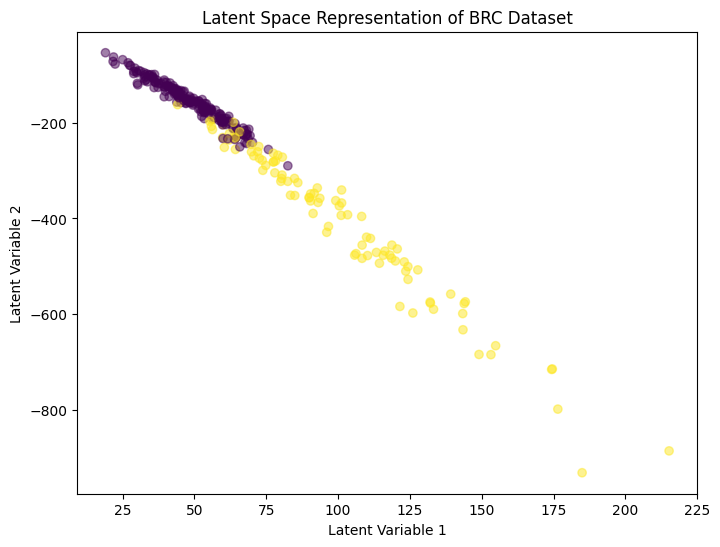

In [ ]:
import matplotlib.pyplot as plt

# Plot encoded data
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_VAE[:, 0], encoded_data_VAE[:, 1], c=y_test, alpha=0.5)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space Representation of BRC Dataset')
plt.show()

In [ ]:
VAE_df = pd.DataFrame(encoded_data_VAE)

#Rename columns
new_column_names = {0: 'VAE1', 1: 'VAE2'}
VAE_df = VAE_df.rename(columns=new_column_names)

# Add target class to the DataFrame
VAE_df['target'] = y_test

In [ ]:
VAE_df

,VAE1,VAE2,target
0,53.420341,-190.989609,1
1,124.360397,-527.434387,2
2,82.503998,-322.335602,2
3,48.231125,-144.085129,1
4,43.080849,-130.734436,1
...,...,...,...
280,61.275509,-190.847717,1
281,35.371552,-104.392632,1
282,34.141243,-100.385208,1
283,44.544968,-145.636215,1


In [ ]:
# Save DataFrame to CSV file in Google Drive
VAE_df.to_csv('/content/drive/My Drive/Datasets/vae2.csv', index=False)